# Linux Command & Wait for Finish

Demonstrate how to launch a (Linux bash) shell command from Python and wait for
it to finish.  This involves setting a command and receiving two different
values (_stdout_ and _stderr_).  A custom subclass of `ophyd.SignalRO` executes
the shell command and processes the results.  We add a `parse_response(stdout,
stderr)` method so any subclass can easily process the string output result of
the Linux command.

To simulate a Linux command to be run, a bash shell script (`doodle.sh`) was
created that runs a countdown (default: 5 seconds) printing to stdout (the
terminal console).

Later, we replace the `doodle.sh` with other common shell commands.


## 1. Example shell command
The example shell command is a bash script that executes a 5 second countdown.  The script is shown first:

In [1]:
!cat ./doodle.sh

#!/bin/bash

echo $(date): Doodle demonstration starting

# optional argument is number of seconds to sleep, default is 5
counter=${1:-5}

until [ $counter -eq 0 ]; do
    echo $(date): countdown ${counter}
    sleep 1
    ((counter--))
done
echo $(date): Doodle demonstration complete


Now, run it to show how it works.

In [2]:
!bash ./doodle.sh

Fri Nov 8 03:54:17 PM CST 2024: Doodle demonstration starting
Fri Nov 8 03:54:17 PM CST 2024: countdown 5
Fri Nov 8 03:54:18 PM CST 2024: countdown 4
Fri Nov 8 03:54:19 PM CST 2024: countdown 3
Fri Nov 8 03:54:20 PM CST 2024: countdown 2
Fri Nov 8 03:54:21 PM CST 2024: countdown 1
Fri Nov 8 03:54:22 PM CST 2024: Doodle demonstration complete


## 2. Run from Python `subprocess`

There are [several
possibilities](https://stackoverflow.com/questions/89228/how-do-i-execute-a-program-or-call-a-system-command)
to run a shell command from Python.  For various reasons, we choose
`subprocess.Popen()` which allows us to start the command in one step, then wait
for the process to complete in another step.

For more details, see the
[documentation](https://docs.python.org/3/library/subprocess.html#subprocess.Popen).

In [3]:
import subprocess
import time

First step: Start the Linux command.

In [4]:
command = "bash ./doodle.sh"

# Start the command
t0 = time.time()
process = subprocess.Popen(
    command,
    shell=True,
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

Second step: Wait for the command to finish.

In [5]:
# wait for the command to finish and collect the outputs.
stdout, stderr = process.communicate()
duration = time.time() - t0
print(f"{duration=:.4f}s")

duration=5.0261s


Show the results.

In [6]:
print(f"{stdout = }")
print(f"{stderr = }")

stdout = b'Fri Nov 8 03:54:22 PM CST 2024: Doodle demonstration starting\nFri Nov 8 03:54:22 PM CST 2024: countdown 5\nFri Nov 8 03:54:23 PM CST 2024: countdown 4\nFri Nov 8 03:54:24 PM CST 2024: countdown 3\nFri Nov 8 03:54:25 PM CST 2024: countdown 2\nFri Nov 8 03:54:26 PM CST 2024: countdown 1\nFri Nov 8 03:54:27 PM CST 2024: Doodle demonstration complete\n'
stderr = b''


Convert from byte strings to plain [utf8](https://en.wikipedia.org/wiki/UTF-8)
text.

In [7]:
# byte strings, must decode to see as string
print(f"stdout\n{stdout.decode('utf8')}")
print(f"stderr\n{stderr.decode('utf8')}")

stdout
Fri Nov 8 03:54:22 PM CST 2024: Doodle demonstration starting
Fri Nov 8 03:54:22 PM CST 2024: countdown 5
Fri Nov 8 03:54:23 PM CST 2024: countdown 4
Fri Nov 8 03:54:24 PM CST 2024: countdown 3
Fri Nov 8 03:54:25 PM CST 2024: countdown 2
Fri Nov 8 03:54:26 PM CST 2024: countdown 1
Fri Nov 8 03:54:27 PM CST 2024: Doodle demonstration complete

stderr



## 3. As `ophyd.SignalRO`

Let's show how to use a *read-only* Signal (`SignalRO`) to execute a
pre-configured Linux shell command.  

We'll execute the shell command in the Signal's `.trigger()` method using
`subprocess.communicate()` in a thread.  The `.trigger()` method returns a
`Status` object.  Once the Linux command finishes, any text returned by the
command will be stored in the Signal's `._readback` attribute (to be returned by
the `.get()` method).  Any error output will be stored in the `.stderr`
attribute.

We redefine the `.trigger()` method in a custom *subclass* of
`ophyd.SignalRO`.

In [ ]:
import ophyd
import threading


class ProcessSignal(ophyd.SignalRO):
    """Signal that returns output from a shell command."""

    command = "bash doodle.sh"
    status = None

    def parse_response(self, stdout, stderr):
        self._readback = stdout.decode("utf8")
        self.stderr = stderr.decode("utf8")

    def trigger(self):
        self.status = ophyd.status.Status()

        def action():
            """Calls command and waits for it to complete."""
            process = subprocess.Popen(
                self.command,
                shell=True,
                stdin=subprocess.PIPE,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
            )

            # wait for the command to finish and collect the outputs.
            self.parse_response(*process.communicate())
            self.status._finished(success=True)

        threading.Thread(target=action, daemon=True).start()
        return self.status  # returns right away

Create the `signal` object.  Print its initial value.

In [9]:
t0 = time.time()
signal = ProcessSignal(name="signal")
print(f"{signal.get()=}")

signal.get()=0.0


The default value of a new `SignalRO` object is `0.0`.  That will change once
`signal` has completed its first Linux command.

Trigger the `signal` (run its `.trigger()` method).  This returns immediately,
before the shell command finishes.  The return result is a `Status` object that
`bluesky` will use to wait for the `.trigger()` operation to finish.

Until the Linux command finishes, the value returned by `signal.get()` is
still unchanged.

In [10]:
status = signal.trigger()
print(f"{signal.get()=}")
print(f"{status = }")
print(f"{time.time()-t0 = }")

signal.get()=0.0
status = Status(obj=None, done=False, success=False)
time.time()-t0 = 0.009106159210205078


We use the `status` object to wait for the Linux command to complete. The shell
script runs for 5 seconds, the status object is done in that time plus a smidgen.

In [11]:
print(f"{status = }")
print(f"{time.time()-t0 = }")
status.wait()

print(f"{signal.get()=}")
print(f"{status = }")
print(f"{time.time()-t0 = }")

status = Status(obj=None, done=False, success=False)
time.time()-t0 = 0.016607999801635742
signal.get()='Fri Nov 8 03:54:27 PM CST 2024: Doodle demonstration starting\nFri Nov 8 03:54:27 PM CST 2024: countdown 5\nFri Nov 8 03:54:28 PM CST 2024: countdown 4\nFri Nov 8 03:54:29 PM CST 2024: countdown 3\nFri Nov 8 03:54:30 PM CST 2024: countdown 2\nFri Nov 8 03:54:31 PM CST 2024: countdown 1\nFri Nov 8 03:54:32 PM CST 2024: Doodle demonstration complete\n'
status = Status(obj=None, done=True, success=True)
time.time()-t0 = 5.027081727981567


## Linux system uptime as a Signal

The elapsed time since the Linux workstation was last started is updated in
virtual file `/proc/uptime`.  The file has two string values: `uptime`
`idletime`.  We want the first one.

We can modify the `ProcessSignal` class and change the `command` and the
`parse_response()` method.

For more details, see the [documentation](https://www.man7.org/linux/man-pages/man5/proc_uptime.5.html).

In [13]:
class UptimeSignal(ProcessSignal):
    command = "cat /proc/uptime"

    def parse_response(self, stdout, stderr):
        self._readback = float(stdout.decode("utf8").split()[0])
        self.stderr = stderr.decode("utf8")


uptime = UptimeSignal(name="uptime")

## Record a time series with the Bluesky Run Engine

When we record a time series of the system uptime, we expect a straight line
plot.  Try it.  First, setup the minimum required bluesky objects.

In [14]:
from bluesky import RunEngine, plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback

RE = RunEngine()
bec = BestEffortCallback()
RE.subscribe(bec)

0

Record the time series.  Here, `uptime` is a detector.  At each step, the
`count` plan will trigger it, wait for the trigger to complete, then read the
signal with its `.read()` method.



Transient Scan ID: 1     Time: 2024-11-08 15:54:33
Persistent Unique Scan ID: 'ff5f04b0-f0ef-483f-8631-39a2f1b49b4f'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     uptime |
+-----------+------------+------------+
|         1 | 15:54:33.3 | 628013.840 |
|         2 | 15:54:34.3 | 628014.830 |
|         3 | 15:54:35.3 | 628015.830 |
|         4 | 15:54:36.3 | 628016.840 |
|         5 | 15:54:37.3 | 628017.840 |
+-----------+------------+------------+
generator count ['ff5f04b0'] (scan num: 1)





('ff5f04b0-f0ef-483f-8631-39a2f1b49b4f',)

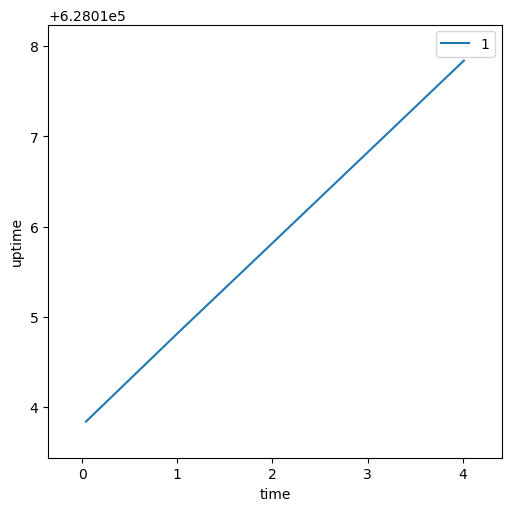

In [15]:
RE(bp.count([uptime], num=5, delay=1))

## Summary

`SignalRO` is the right class to use for a shell command that returns a single value.

One might think the `ophyd.Signal` class could be used where the command would
be put and the returned value would be as above.  The problem is the design of
the `Signal.put()` method.

The `ophyd.Signal.put()` method requests the Signal to go to the `value` and
then waits for it to get there (that's when it uses up its status object).  The
output of the shell command will *never* become the value of the command string.
If we were to set `obj._readback` to be the output from the shell command, then
the `put()` method would never return (it hangs because the readback value does
not equal the input value).

`SignalRO`, not `Signal`, is the right interface.